# Hypothesis prioritization and A/B testing

### Goal

Together with marketing department, we've compiled a list of hypotheses that may help boost revenue. We need to prioritize these hypotheses, launch an A/B test, and analyze the results.

### Table of Contents
0. [Data preprocessing](#data_preprocessing)
1. [Hypothesis prioritization](#hypothesis_prioritization)
2. [A/B Test Analysis](#a_b_testing)
3. [Statistical significance](#statistical_significance)
4. [Conclusion](#conclusion)

### Description of the data

- The `hypothesis.csv` file contains nine hypotheses on boosting an online store's revenue with Reach, Impact, Confidence, and Effort specified for each.
- The `orders.csv` file contains data on orders made in the online store during the A/B test.
- The `visitors.csv` file contains data on visits to the online store during the A/B test.

*Group A* is the control group, *group B* is the test group.

### Libraries Used
The following libraries were used: `pandas`, `matplotlib`, `numpy`, `scipy.stats`

### Data Preprocessing <a class="anchor" id="data_preprocessing"></a>

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

print()
hypothesis_df = pd.read_csv('hypothesis.csv')
print(hypothesis_df.info())

print()
orders_df = pd.read_csv('orders.csv')
print(orders_df.info())

print()
visitors_df = pd.read_csv('visitors.csv')
print(visitors_df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 co

In [61]:
# Convert date columns to datetime type and rename columns
hypothesis_df.columns = hypothesis_df.columns.str.lower()
orders_df.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders_df['date'] = pd.to_datetime(orders_df['date'])
visitors_df['date'] = pd.to_datetime(visitors_df['date'])

# Check for duplicates
print()
print('Number of duplicates in hypothesis_df:', hypothesis_df.duplicated().sum())
print('Number of duplicates in orders_df:', orders_df.duplicated().sum())
print('Number of duplicates in visitors_df:', visitors_df.duplicated().sum())


Number of duplicates in hypothesis_df: 0
Number of duplicates in orders_df: 0
Number of duplicates in visitors_df: 0


### Hypothesis prioritization <a class="anchor" id="hypothesis_prioritization"></a>

In [62]:
# Creating ICE and RICE scores for each hypothesis
hypothesis_df['ICE'] = (hypothesis_df['impact'] * hypothesis_df['confidence']) / hypothesis_df['efforts']
hypothesis_df['RICE'] = (hypothesis_df['reach'] * hypothesis_df['impact'] * hypothesis_df['confidence']) / hypothesis_df['efforts']

pd.set_option('display.max_colwidth', 0)
print(hypothesis_df.sort_values(by='ICE', ascending=False))
print(hypothesis_df.sort_values(by='RICE', ascending=False))

                                                                                                                  hypothesis  \
8  Launch a promotion that gives a discount on goods on your birthday                                                          
0  Add two new channels to attract traffic, which will attract 30% more users                                                  
7  Add a subscription form to all main pages to build a customer base for email newsletters                                    
6  Display banners with current promotions and sales on the main page to increase conversion                                   
2  Add product recommendation blocks to the online store website to increase conversion and average check of the order         
1  Launch your own delivery service, which will reduce the delivery time of orders                                             
5  Add a customer reviews page about the store, which will increase the number of orders                

Hypotheses were prioritized using the ICE and RICE frameworks. 
Two of them were in the top 3 for both frameworks: 7 and 0.
Hypothesis 7 is about `adding a subscription form to all the most popular pages`. It has the highest RICE score because it has the highest _reach_ (10) and high _impact_ (7) and at the same time medium _effort_ (5). Hypothesis 0 is about `adding two new channels for attracting traffic`. It has the highest _impact_ (10) and high _confidence_ (8) but low _reach_ (3) and high _effort_ (6).

Since ID 7 hypothesis has the highest RICE score, and lower effort than ID 0, it was chosen as the most promising hypothesis.

### A/B Test Analysis <a class="anchor" id="a_b_testing"></a>

#### Cumulative data by date and group

In [63]:
# Unique pairs of date and group
date_groups = orders_df[['date', 'group']].drop_duplicates()

# Cumulative data on orders for each date and group
orders_cumulative = date_groups.apply(
    lambda x: orders_df[
        np.logical_and(
            orders_df['date'] <= x['date'],
            orders_df['group'] == x['group']
        )].agg({
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum'
        }), axis=1
    ).sort_values(by=['date', 'group'])
            
# Cumulative data on visitors for each date and group
visitors_cumulative = date_groups.apply(
    lambda x: visitors_df[
        np.logical_and(
            visitors_df['date'] <= x['date'],
            visitors_df['group'] == x['group']
        )].agg({
            'date': 'max',
            'group': 'max',
            'visitors': 'sum'
        }), axis=1
    ).sort_values(by=['date', 'group'])

# Merging cumulative data into one table
cumulative_data = orders_cumulative.merge(visitors_cumulative, on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# create 2 revenue dataframes: one for group A and one for group B
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

print(cumulative_revenue_a.head())
print(cumulative_revenue_b.head())

        date  revenue  orders
0 2019-08-01  148579   24    
2 2019-08-02  242401   44    
4 2019-08-03  354874   68    
6 2019-08-04  425699   84    
8 2019-08-05  549917   109   
        date  revenue  orders
1 2019-08-01  101217   21    
3 2019-08-02  266748   45    
5 2019-08-03  380996   61    
7 2019-08-04  489567   78    
9 2019-08-05  581995   101   


#### Revenue by group in time

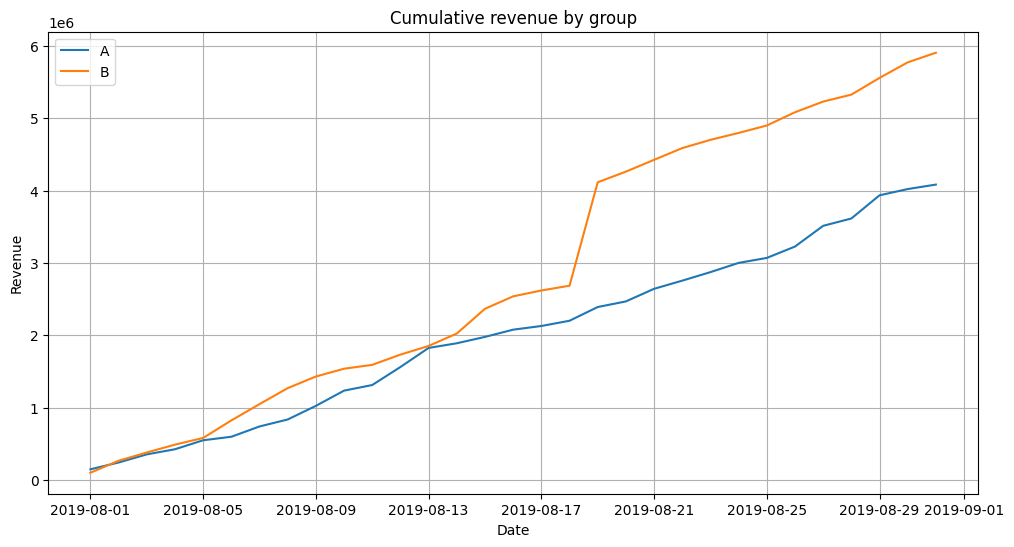

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('Cumulative revenue by group')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid()
plt.show()

Revenue is growing steadily throughout the whole test. However, on `2019-08-18` there was a sharp increase in revenue in group B. This may be due to a large order or a group of orders. *Group A*'s revenue is also growing steadily, but at a slower and more stable pace.

#### Average revenue per order by group in time

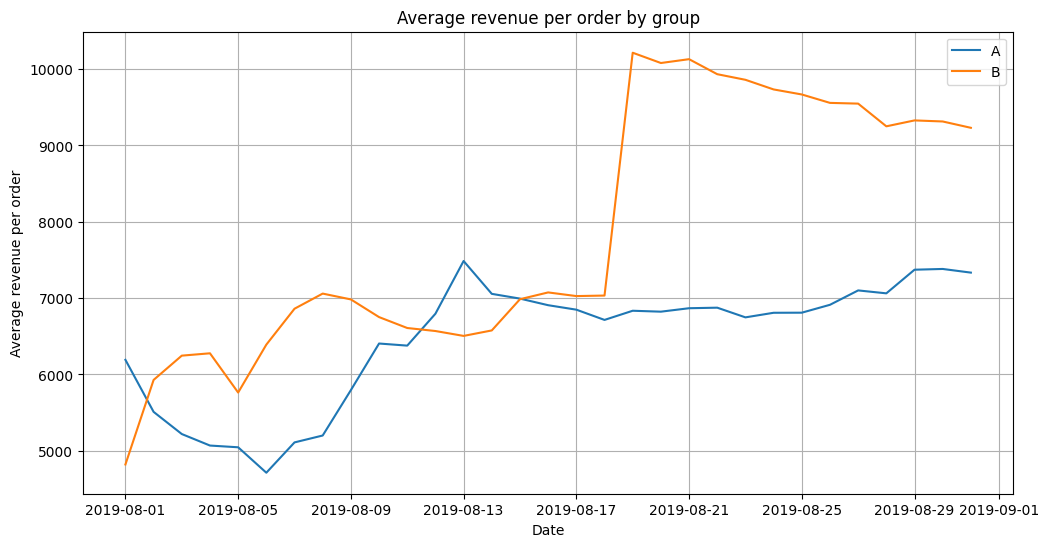

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], label='B')
plt.title('Average revenue per order by group')
plt.xlabel('Date')
plt.ylabel('Average revenue per order')
plt.legend()
plt.grid()
plt.show()


Average revenue per order is pretty volatile for both groups in the first half of the test. However, in the second half of the test, it stabilizes for groups A and B, but again there is a sharp increase in group B on `2019-08-18`. 

#### Relative difference in average revenue per order

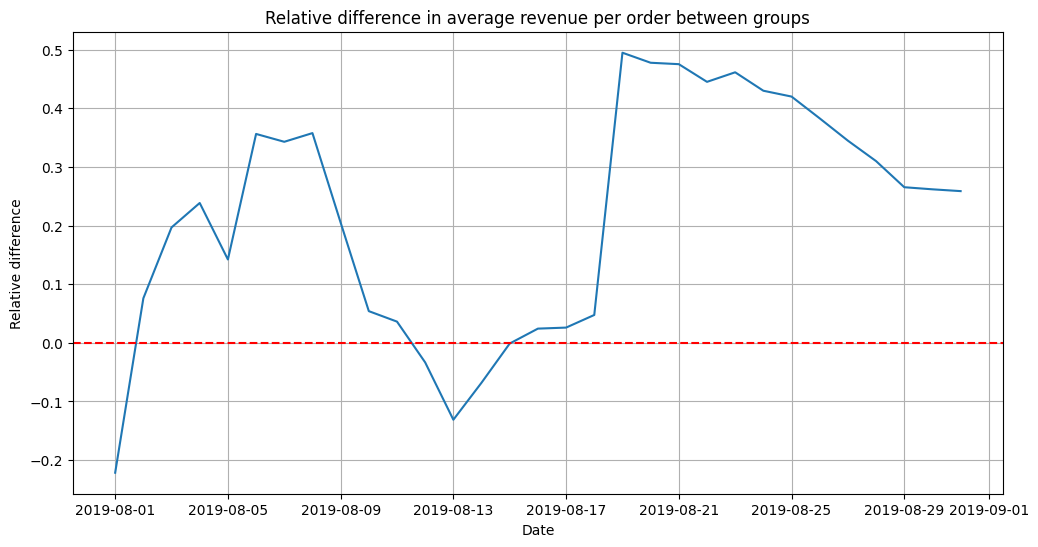

In [66]:
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, on='date', how='left', suffixes=['_a', '_b'])

plt.figure(figsize=(12, 6))
plt.plot(
    merged_cumulative_revenue['date'],
    (merged_cumulative_revenue['revenue_b'] / merged_cumulative_revenue['orders_b']) / (merged_cumulative_revenue['revenue_a'] / merged_cumulative_revenue['orders_a']) - 1
)
plt.title('Relative difference in average revenue per order between groups')
plt.xlabel('Date')
plt.ylabel('Relative difference')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid()
plt.show()

Most of the time *Group B* has higher average revenue per order than *Group A*. However, there are several spikes when *Group A* has higher average revenue per order than *Group B*. The largest spike is on `2019-08-13`. Again there is a sharp increase in *Group B* on `2019-08-18`.

#### Cumulative conversion rates by group

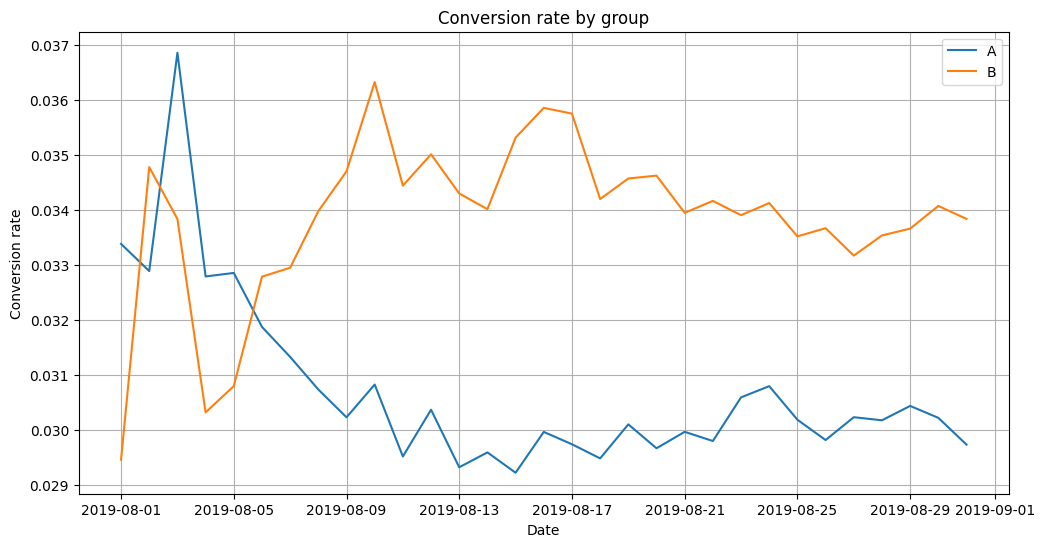

In [67]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

plt.figure(figsize=(12, 6))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.title('Conversion rate by group')
plt.xlabel('Date')
plt.ylabel('Conversion rate')
plt.legend()
plt.grid()
plt.show()


In the beginning, *Group A* had a higher conversion rate than *Group B*. However, on `2019-08-06` *Group B* overtook *Group A* and has been stabilizing since then. *Group A* has conversion rate fluctuations around 0.03, while *Group B* has fluctuations around 0.034.

#### Relative difference in conversion rates

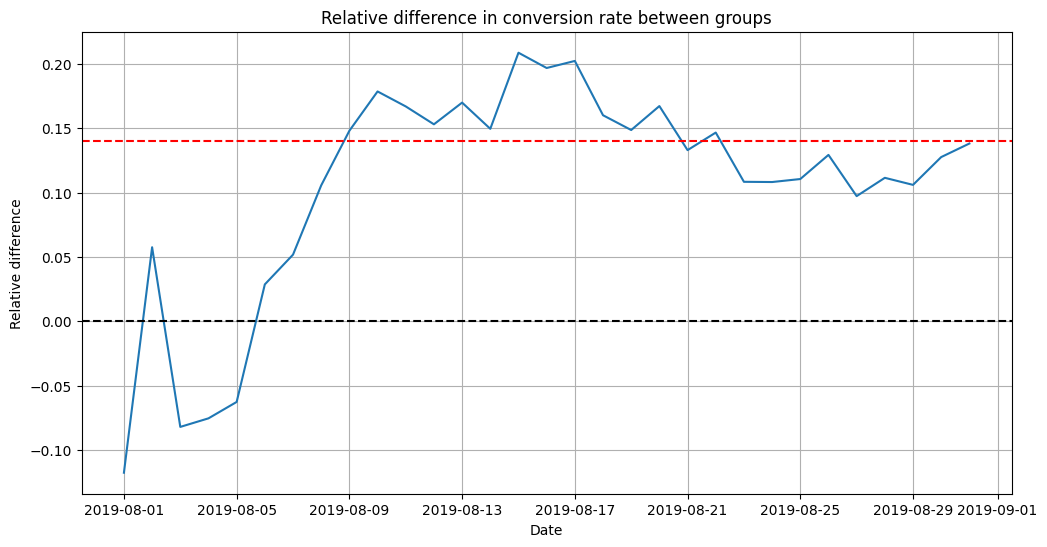

In [68]:
merged_cumulative_conversion = cumulative_data_a[['date', 'conversion']].merge(cumulative_data_b[['date', 'conversion']], on='date', how='left', suffixes=['_a', '_b'])

plt.figure(figsize=(12, 6))
plt.plot(merged_cumulative_conversion['date'], merged_cumulative_conversion['conversion_b'] / merged_cumulative_conversion['conversion_a'] - 1)
plt.title('Relative difference in conversion rate between groups')
plt.xlabel('Date')
plt.ylabel('Relative difference')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='red', linestyle='--')
plt.grid()
plt.show()

*Group B* has a higher conversion rate than *Group A* most of the time. The difference is around 14%.

#### Scatter plot of the number of orders per user

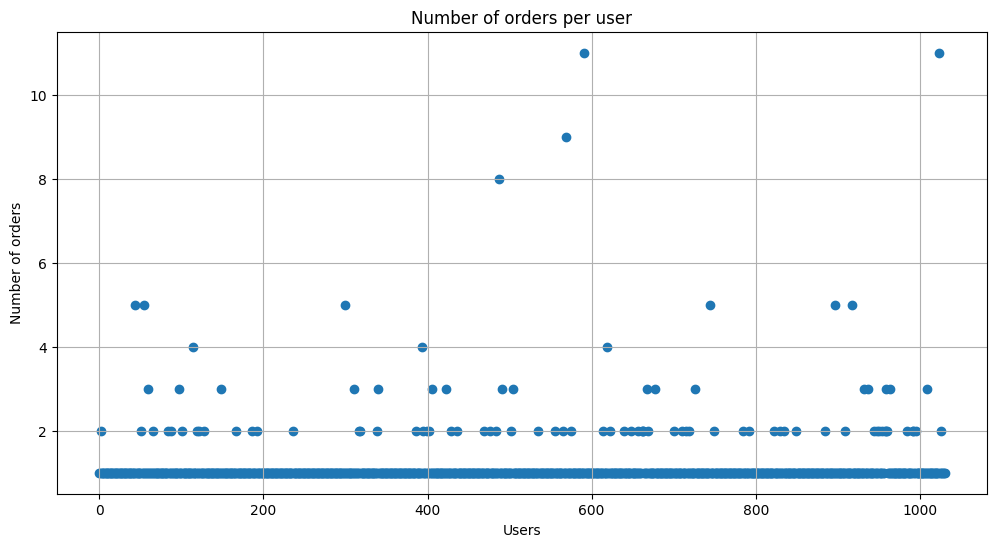

In [69]:
orders_by_users = orders_df.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
orders_by_users.columns = ['visitor_id', 'orders']

x_values = pd.Series(range(0, len(orders_by_users)))

plt.figure(figsize=(12, 6))
plt.scatter(x_values, orders_by_users['orders'])
plt.title('Number of orders per user')
plt.xlabel('Users')
plt.ylabel('Number of orders')
plt.grid()
plt.show()

Most of the users have made less then 3 orders. Let's find the 95th and 99th percentiles.

In [70]:
print(f'95% of users have no more than {np.percentile(orders_by_users["orders"], 95)} orders')
print(f'99% of users have no more than {np.percentile(orders_by_users["orders"], 99)} orders')

95% of users have no more than 2.0 orders
99% of users have no more than 4.0 orders


We are taking the 95% percentile as the cut-off point for the number of orders per user. Users with more than 2 (>= 3) orders will be considered abnormal.

#### Scatter plot of order prices

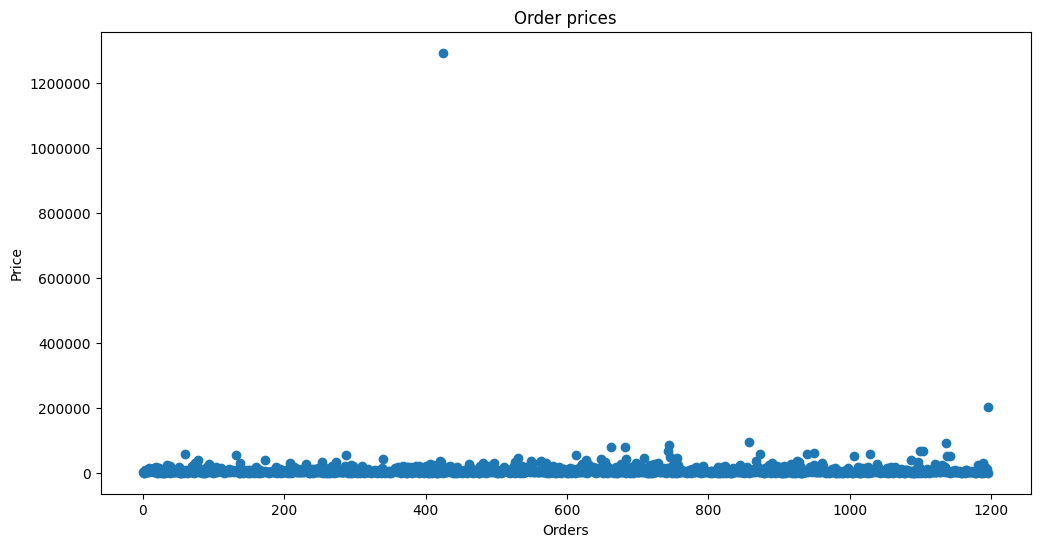

In [71]:
x_values = pd.Series(range(0, len(orders_df['revenue'])))
plt.figure(figsize=(12, 6))
plt.scatter(x_values, orders_df['revenue'])
plt.title('Order prices')
plt.xlabel('Orders')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Price')
plt.show()

We can see that most of the orders are way less than `200000`except for couple of outliers. Let's find the 95th and 99th percentiles. 

In [72]:
print(f'95% of orders cost no more than {round(np.percentile(orders_df["revenue"], 95), 2)}')
print(f'99% of orders cost no more than {round(np.percentile(orders_df["revenue"], 99), 2)}')

95% of orders cost no more than 28000.0
99% of orders cost no more than 58233.2


As we can see, the 95th percentile is `28000` and the 99th percentile is `58233`. We will take `28000` as the cut-off point for the order prices. Orders with prices higher than `28000` will be considered abnormal.

### Statistical significance of A/B test results <a class="anchor" id="statistical_significance"></a>

#### Data preparation for hypothesis testing

In [73]:
visitors_a_daily = visitors_df[visitors_df['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']
visitors_b_daily = visitors_df[visitors_df['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_a_cumulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg({
        'date': 'max',
        'visitors_per_date_a': 'sum'
    }), axis=1).sort_values(by='date')
visitors_a_cumulative.columns = ['date', 'visitors_cumulative_a']

visitors_b_cumulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg({
        'date': 'max',
        'visitors_per_date_b': 'sum'
    }), axis=1).sort_values(by='date')
visitors_b_cumulative.columns = ['date', 'visitors_cumulative_b']

orders_a_daily = orders_df[orders_df['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']].groupby('date', as_index=False).agg({
    'transaction_id': 'nunique',
    'visitor_id': 'nunique'
})
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_b_daily = orders_df[orders_df['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']].groupby('date', as_index=False).agg({
    'transaction_id': 'nunique',
    'visitor_id': 'nunique'
})
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_a_cumulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg({
        'date': 'max',
        'orders_per_date_a': 'sum',
        'revenue_per_date_a': 'sum'
    }), axis=1).sort_values(by='date')
orders_a_cumulative.columns = ['date', 'orders_cumulative_a', 'revenue_cumulative_a']

orders_b_cumulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg({
        'date': 'max',
        'orders_per_date_b': 'sum',
        'revenue_per_date_b': 'sum'
    }), axis=1).sort_values(by='date')
orders_b_cumulative.columns = ['date', 'orders_cumulative_b', 'revenue_cumulative_b']

data = (
    orders_a_daily.merge(orders_b_daily, on='date', how='left')
    .merge(orders_a_cumulative, on='date', how='left')
    .merge(orders_b_cumulative, on='date', how='left')
    .merge(visitors_a_daily, on='date', how='left')
    .merge(visitors_b_daily, on='date', how='left')
    .merge(visitors_a_cumulative, on='date', how='left')
    .merge(visitors_b_cumulative, on='date', how='left')
)

orders_by_users_a = orders_df[orders_df['group'] == 'A'].groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = orders_df[orders_df['group'] == 'B'].groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
orders_by_users_b.columns = ['user_id', 'orders']

sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')
    ],
    axis=0
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')
    ],
    axis=0
)


Next we will find the statistical significance of the difference in average order total and average orders amount between the groups using the raw data. We will use the Mann-Whitney test since the data is not normally distributed. Alpha value will be set to 0.05. 

#### Statistical significance of the difference in average orders amount between the groups

Hypotheses:
- **H0**: There is no statistically significant difference in average orders amount between the groups.
- **H1**: There is a statistically significant difference in average orders amount between the groups.

In [74]:
alpha = 0.05

results = stats.mannwhitneyu(sample_a, sample_b, alternative='two-sided')
print('p-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')
    
print('Relative difference in orders amount average: {0:.2%}'.format(sample_b.mean() / sample_a.mean() - 1))

p-value: 0.017
Reject H0
Relative difference in orders amount average: 13.81%


`P-value` is 0.017 and is less than 0.05. We **reject** the null hypothesis. There is a statistically significant difference in *average orders amount* between the groups.

#### Significant statistical difference in average revenue between the groups

Hypotheses:
- **H0**: There is no statistically significant difference in average order size between the groups.
- **H1**: There is a statistically significant difference in average order size between the groups.

In [75]:
results = stats.mannwhitneyu(
    orders_df[orders_df['group'] == 'A']['revenue'],
    orders_df[orders_df['group'] == 'B']['revenue'],
    alternative='two-sided'
)

print('p-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')
    
print('Relative difference in revenue average: {0:.2%}'.format(orders_df[orders_df['group'] == 'B']['revenue'].mean() / orders_df[orders_df['group'] == 'A']['revenue'].mean() - 1))

p-value: 0.729
Fail to reject H0
Relative difference in revenue average: 25.87%


`P-value` is 0.729 and is more than 0.05. We **fail to reject** the null hypothesis. There is no statistically significant difference in *average order size* between the groups.

#### Removing outliers from the data

In [76]:
# Table of users with more then 2 orders
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 2]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 2]['user_id']
    ],
    axis=0
)

users_with_expenisve_orders = orders_df[orders_df['revenue'] > np.percentile(orders_df['revenue'], 95)]['visitor_id']

a_b_outliers = pd.concat(
    [
        users_with_many_orders,
        users_with_expenisve_orders
    ],
    axis=0
).drop_duplicates().sort_values()

sample_a_filtered = pd.concat(
    [
        orders_by_users_a[~(orders_by_users_a['user_id'].isin(a_b_outliers))]['orders'],
        pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')
    ],
    axis=0
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[~(orders_by_users_b['user_id'].isin(a_b_outliers))]['orders'],
        pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')
    ],
    axis=0
)


#### Statistical significance of the difference in average orders amount between the groups without outliers

Hypotheses:
- **H0**: There is no statistically significant difference in average orders amount between the groups.
- **H1**: There is a statistically significant difference in average orders amount between the groups.

In [77]:
results = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered, alternative='two-sided')

print('p-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')
    
print('Relative difference in orders amount average: {0:.2%}'.format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))


p-value: 0.013
Reject H0
Relative difference in orders amount average: 17.27%


Without outliers `P-value` is 0.013 and is less than 0.05. We **reject** the null hypothesis. There is a statistically significant difference in *average orders amount* between the groups. And the relative difference is even higher than with outliers.

#### Statistical significance of the difference in average revenue between the groups without outliers

Hypotheses:
- **H0**: There is no statistically significant difference in average order size between the groups.
- **H1**: There is a statistically significant difference in average order size between the groups.


In [78]:
results = stats.mannwhitneyu(
    orders_df[(orders_df['group'] == 'A') & ~(orders_df['visitor_id'].isin(a_b_outliers))]['revenue'],
    orders_df[(orders_df['group'] == 'B') & ~(orders_df['visitor_id'].isin(a_b_outliers))]['revenue'],
    alternative='two-sided'
)

print('p-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:

    print('Reject H0')
else:
    print('Fail to reject H0')
    
print('Relative difference in revenue average: {0:.2%}'.format(orders_df[(orders_df['group'] == 'B') & ~(orders_df['visitor_id'].isin(a_b_outliers))]['revenue'].mean() / orders_df[(orders_df['group'] == 'A') & ~(orders_df['visitor_id'].isin(a_b_outliers))]['revenue'].mean() - 1))



p-value: 0.738
Fail to reject H0
Relative difference in revenue average: -1.96%


Without outliers `P-value` is 0.738 and is more than 0.05. We **fail to reject** the null hypothesis. There is no statistically significant difference in *average order size* between the groups. Moreover, the relative difference is even lower and is negative.

### Conclusion <a class="anchor" id="conclusion"></a>

#### Decision on implementing the feature

**The test is Green.**
Here are some results of the test:
 - *Group B* has a statisticaly significant difference in` average orders amount` both with outliers and without them, we can conclude that the feature is working. However, there is no statisticaly significant difference in average revenue between the groups. 
 - The relative difference in `average orders amount` is 25% with outliers and 17% without them.
 - The relative difference in `average revenue` is 25% with outliers (and because of them) and -2% without them. Those numbers are not statistically significant.

